### Multi-Label-Klassifikation

#### Dataset


In [2]:
#  In diesem Datensatz kann jedes Bild mehrere Objekte enthalten 
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

Anders als bei anderen Datensätzen:

    * Die Bilder sind nicht in Ordnern nach Klassen sortiert

    * Stattdessen gibt es eine CSV-Datei, in der steht:

        * Welches Bild

        * Welche Labels

        * Ob es für Training oder Validierung ist

In [4]:
import pandas as pd
df = pd.read_csv(path/'train.csv')
df.head(10)


,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True
5,000017.jpg,person horse,False
6,000019.jpg,cat,True
7,000020.jpg,car,True
8,000021.jpg,dog person,True
9,000023.jpg,bicycle person,False


In [6]:
df.iloc[0]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

#### Einen DataBlock bauen (Datensatz vorbereiten)

##### DataLoaders-Objekt erstellen
* Dataset: Gibt bei jedem Aufruf ein (Eingabe, Ziel)-Paar zurück – z. B. ein Bild & seine Labels
* DataLoader: Baut daraus Mini-Batches für das Training (z. B. 64 Bilder auf einmal)

Zusätzlich gibt’s in FastAI:

    * Datasets: enthält Trainings- und Validierungs-Dataset

    * DataLoaders: enthält Trainings- und Validierungs-DataLoader

In [ ]:
# 1. Ganz leer starten:
dblock = DataBlock()
dsets = dblock.datasets(df)

In [ ]:
# 2. Eingabe & Ziel richtig zuweisen:
# Jetzt zeigt sich: ('002549.jpg', 'tvmonitor')

def get_x(r): return r['fname']
def get_y(r): return r['labels']
dblock = DataBlock(get_x = get_x, get_y = get_y)


In [9]:
# 3. Datei öffnen & Label aufteilen:
# (Path('/.../008663.jpg'), ['car', 'person'])

def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')


#### DataBlock mit MultiCategoryBlock erstellen:
Normalerweise nutzt man CategoryBlock (für genau ein Label pro Bild)
* Das geht hier nicht, weil wir mehrere Labels pro Bild brauchen

Deshalb:
* MultiCategoryBlock benutzen

Das erzeugt One-Hot-Vektoren:
* Eine Liste mit 0 und 1
* 1 bedeutet: Diese Klasse ist vorhanden

In [10]:
dblock = DataBlock(
  blocks=(ImageBlock, MultiCategoryBlock),
  get_x=get_x,
  get_y=get_y
)
dsets = dblock.datasets(df)

In [11]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]
# z. B. ['dog']


(#2) ['bird','cow']

#### Train/Test-Aufteilung (Splitter definieren)
Bis jetzt wurde zufällig aufgeteilt – aber wir haben ja eine Spalte is_valid, die sagt, was zur Validierung gehört!

In [13]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train, valid


dblock = DataBlock(
  blocks=(ImageBlock, MultiCategoryBlock),
  splitter=splitter,
  get_x=get_x,
  get_y=get_y
)

#### Bilder zuschneiden für einheitliche Größe
Modelle brauchen gleich große Bilder – deshalb verwenden wir einen Transform

In [14]:
item_tfms = RandomResizedCrop(128, min_scale=0.35)

dblock = DataBlock(
  blocks=(ImageBlock, MultiCategoryBlock),
  splitter=splitter,
  get_x=get_x,
  get_y=get_y,
  item_tfms = item_tfms
)

In [15]:
# DataLoaders erzeugen:
dls = dblock.dataloaders(df)

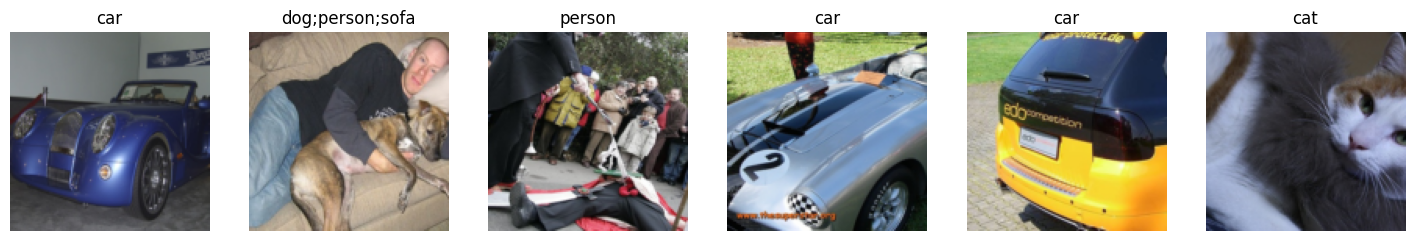

In [17]:
dls.show_batch(nrows=1, ncols=6)

In [18]:
dblock.summary(df)

Setting-up type transforms pipelines
0     000005.jpg           chair      True
1     000007.jpg             car      True
2     000009.jpg    horse person      True
3     000012.jpg             car     False
4     000016.jpg         bicycle      True
...          ...             ...       ...
5006  009954.jpg    horse person      True
5007  009955.jpg            boat      True
5008  009958.jpg  person bicycle      True
5009  009959.jpg             car     False
5010  009961.jpg             dog     False

[5011 rows x 3 columns]
Found 5011 items
2 datasets of sizes 2501,2510
Setting up Pipeline: get_x -> PILBase.create
Setting up Pipeline: get_y -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False}
 -> OneHotEncode -- {'c': None}


Building one sample
  Pipeline: get_x -> PILBase.create
    starting from
      fname       000012.jpg
labels             car
is_valid         False
Name: 3, dtype: object
    applying get_x gives
      /home/lukelo-tshakulongo/.fastai/data/pa

### Training
* Modell (z. B. ResNet18)

* DataLoaders (haben wir schon)

* Optimierer (z. B. SGD)

* Loss-Funktion (Fehlermessung)

In [19]:
learn = cnn_learner(dls, resnet18)

/home/lukelo-tshakulongo/Bankoko/φ-σ-Ω/Computer Science/Code/Mulandu/DLConcepts/venv/lib/python3.12/site-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

x = x.to(device)
learn.model = learn.model.to(device)
activs = learn.model(x)

In [ ]:
# 64 Bilder (Batch-Größe)
# 20 mögliche Klassen
    # Für jedes Bild: 20 Vorhersagewerte

activs 

torch.Size([64, 20])

In [ ]:
# Für jedes Bild: 20 Vorhersagewerte
# Diese Werte sind noch keine Wahrscheinlichkeiten!
# Wir wenden zuerst eine Sigmoid-Funktion an, um sie auf den Bereich 0 bis 1 zu skalieren.
activs[0]

TensorImage([ 2.6152, -0.3131,  0.2797, -1.4070, -1.9630, -0.6471, -1.2876,
              0.0508, -3.8044,  1.4599,  2.6489,  0.3570,  1.0805,  0.8881,
             -0.1969, -1.6614,  1.9759,  0.2254, -0.3943, -3.9153],
            device='cuda:0', grad_fn=<AliasBackward0>)

#### Loss-Funktion
Für Multi-Label brauchen wir Binary Cross Entropy mit Sigmoid.
+ nn.BCEWithLogitsLoss()
    + Das kombiniert Sigmoid
    + Binary Cross Entropy


In [ ]:
# manuell einstllen
# EWithLogitsLoss

# Vergleicht jede Vorhersage mit dem Ziel für jede Klasse einzeln – genau, was wir brauchen!
loss_func = nn.BCEWithLogitsLoss()

# Konvertiere FastAI Tensoren zu regulären PyTorch Tensoren
activs = activs.as_subclass(torch.Tensor)
y = y.float().as_subclass(torch.Tensor)  # Achtung: BCE braucht float targets

loss = loss_func(activs, y)
print(loss)

tensor(1.0775, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


#### Genauigkeit messen bei Multi-Label
Das nutzt argmax – geht nicht, weil wir mehr als eine richtige Klasse pro Bild haben!

In [26]:
# Neue Funktion: accuracy_multi
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    if sigmoid: inp = inp.sigmoid()
    return ((inp > thresh) == targ.bool()).float().mean()

#### Threshold anpassen:
* thresh=0.1 → sehr viele Labels werden als vorhanden erkannt (auch falsche)
* thresh=0.99 → nur sehr sichere Labels werden erkannt

In [27]:
from functools import partial
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)


/home/lukelo-tshakulongo/Bankoko/φ-σ-Ω/Computer Science/Code/Mulandu/DLConcepts/venv/lib/python3.12/site-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.955780,0.697329,0.228187,00:11
1,0.827065,0.545940,0.289223,00:10
2,0.602995,0.202372,0.800498,00:10
3,0.356588,0.116190,0.945339,00:10


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.128540,0.102504,0.950259,00:14
1,0.113399,0.095707,0.956932,00:12
2,0.099087,0.093790,0.958705,00:12


In [28]:
# Du kannst experimentieren:
preds, targs = learn.get_preds()
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)


tensor(0.9588)

##### Bester Threshold finden
Kurve zeigt, wo der beste Schwellenwert ist.
Solange sie glatt ist, kannst du sicher den besten Wert wählen, ohne Overfitting zu befürchten.

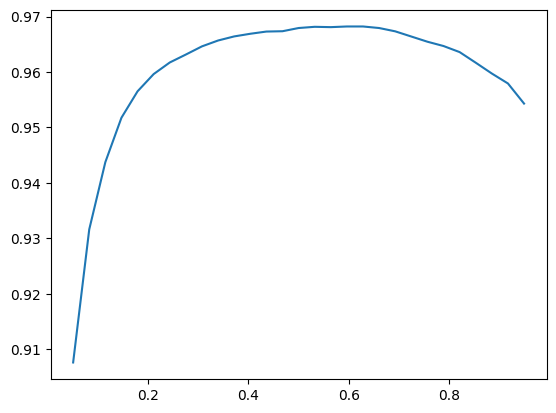

In [29]:
xs = torch.linspace(0.05, 0.95, 29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs, accs)


# Regression
Ein Modell wird nicht durch den Anwendungsbereich definiert,
sondern durch:

+ Eingabevariable (X)
+ Zielvariable (Y)
+ Loss-Funktion